This notebook is much more exploratory than method 1, and I am going to avoid documenting much of it unless there is a demand.

TLDR: expanding the heel search space does not seem to yield better solutions!

This notebook does three things:
-The search space can be arbitrarily expanded
-Two larger search spaces are explored and the resulting number of turns and crossings are plotted. Due to the way the code is written, it just prints the number of turns and crossings when it finds a solution, and I copy pasted these results into a cell and plot them, there is a lot of scrolling to do (sorry). For this reason I am not able to easily display the actual paths, if this exploration ever yielded better solutions I would have added this capability.
-The underlying data structures used for search are made in a way that can be ported into C (so it can be paralellized across different search paths) and use very inexpensive operations (mainly modulus). Again, based on the results from expanding the search twice, this probably would not yield better solutions, so it has not been tried.


In [1]:
import copy


start = 2
fin = 0
size_array = (4 + max((start-1),fin),8 + max((start-3)*2,fin*2))
starting_array = [[6 for n in range(size_array[1])] for c in range(size_array[0])]


a1,a2 = 1,0
b1,b2 = 1,1
c1, c2 = 2,0
d1, d2 = 2,1

e1, e2 = 2,6
f1, f2 = 2,7
g1, g2 = 3,6
h1, h2 = 3,7

for i in range(8):
    starting_array[0][i] = 5
for i in range(2,8):
    starting_array[1][i] = 5
for i in range(4,6):
    starting_array[2][i] = 5

while start > 0:
    starting_array[a1][a2] = 5
    starting_array[b1][b2] = 5
    starting_array[c1][c2] = 5
    starting_array[d1][d2] = 5
    a1 += 1
    a2 += 2
    b1 += 1
    b2 += 2
    c1 += 1
    c2 += 2
    d1 += 1
    d2 += 2
    start -= 1
starting_array[a1][a2] = 0
starting_array[b1][b2] = 1
starting_array[c1][c2] = 2
starting_array[d1][d2] = 3

fin += 1 #hacky
while fin > 0:
    starting_array[e1][e2] = 5
    starting_array[f1][f2] = 5
    starting_array[g1][g2] = 5
    starting_array[h1][h2] = 5
    e1 += 1
    e2 += 2
    f1 += 1
    f2 += 2
    g1 += 1
    g2 += 2
    h1 += 1
    h2 += 2
    fin -= 1
    
fin2_ubound = 7 + fin*2
fin2_lbound = 6 + fin*2
fin1_ubound = 3 + fin
fin1_lbound = 2 + fin

def is_fin(v1,v2):
    return (v1 == fin1_lbound or v1 == fin1_ubound) and (v2 == fin2_lbound or v2 == fin2_ubound) 

rec = []
for r in range(4):
    toadd = []
    for c in range(8):
        toadd.append(is_fin(r,c))
    rec.append(toadd)

# [[ 5, 5, 5, 5, 5, 5, 5, 5],
#  [ 0, 1, 5, 5, 5, 5, 5, 5],
#  [ 2, 3, 6, 6, 5, 5, 5, 5],
#  [ 6, 6, 6, 6, 6, 6, 5, 5]]
#use mod 7

In [2]:

def print_arr(arr):
    for r in arr:
        print(r)
    print()
print_arr(starting_array)
print_arr(rec)

[5, 5, 5, 5, 5, 5, 5, 5]
[5, 5, 5, 5, 5, 5, 5, 5]
[5, 5, 5, 5, 5, 5, 5, 5]
[6, 6, 5, 5, 0, 1, 5, 5]
[6, 6, 6, 6, 2, 3, 6, 6]

[False, False, False, False, False, False, False, False]
[False, False, False, False, False, False, False, False]
[False, False, False, False, False, False, True, True]
[False, False, False, False, False, False, True, True]



In [3]:

#notes: this is probably very inefficient but whatever
def turns_and_crosses(oarr):
#takes in search result and gives [[(r,c),...],[],[],[]]
#also tacks on to account for extra turns and crossings from the entrance and exit +1r +2c
    arr = copy.deepcopy(oarr)
    p = [[],[],[],[]]
    for m in range(4):
        t = m
        while 1:
            found = False
            for r in range(len(arr)):
                for c in range(len(arr[0])):
                    if arr[r][c] == t:
                        p[t%7].append((r,c))
                        found = True
            if not found:
                break
            t += 7
    for path in p:
        first = path[0]
        path.insert(0,(first[0] + 1,first[1] + 2))
        last = path[-1]                
        path.append((last[0] + 1,last[1] + 2))
    return p
                

In [4]:
def ccw(A,B,C):
    return (C[1]-A[1]) * (B[0]-A[0]) > (B[1]-A[1]) * (C[0]-A[0])

# Return true if line segments AB and CD intersect
def intersect(A,B,C,D):
    return ccw(A,C,D) != ccw(B,C,D) and ccw(A,B,C) != ccw(A,B,D) and (A != C and A != D and B != C and B != D)

def count_crossings(p):
    segs = set()
    intersects = 0
    for knight in p:
        for i in range(len(knight)-1):
            new_seg = (knight[i],knight[i+1])
            for other_seg in segs:
                if intersect(new_seg[0],new_seg[1],other_seg[0],other_seg[1]):
                    intersects +=1
                    #print(new_seg[0],new_seg[1],other_seg[0],other_seg[1])
                    #plt.plot([new_seg[0][0],new_seg[1][0]],[new_seg[0][1],new_seg[1][1]])
                    #plt.plot([other_seg[0][0],other_seg[1][0]],[other_seg[0][1],other_seg[1][1]])
                    #plt.show()
            segs.add(new_seg)
    return intersects

def count_turns(p):
    turns = 0
    for knight in p:
        curr_x = None
        curr_y = None
        for i in range(1,len(knight)):
            new_x = knight[i][0] - knight[i-1][0]
            new_y = knight[i][1] - knight[i-1][1]
            
            if (curr_x != new_x or curr_y != new_y) and curr_x != None:
                turns += 1
            curr_x = new_x
            curr_y = new_y
    return turns

In [5]:
depth_hist = [0 for n in range(100)]
def search(locs, #[a1,a2,b1,b2,...]
           arr,
           extend_idx = 0, depth = 0):
    found = False
    for d_extend in range(4):
        i1,i2 = extend_idx*2,extend_idx*2 + 1
        v1,v2 = locs[i1], locs[i2]
        
        if not is_fin(v1,v2):
            found = True
            break
        extend_idx = (extend_idx + 1) % 4 
    if not found:
        for r in arr:
            for c in r:
                if c % 7 == 5:
                    return
        #print_arr(arr)
        o = turns_and_crosses(arr)
        print("(" + str(count_crossings(o)) + "," +  str(count_turns(o)) +"),")
       
        return
        #verify that all squares got hit (no v % 7 == 5) and return
    
    for diff1,diff2 in [(-2,-1),(-2,1),(-1,-2),(-1,2),(1,-2),(1,2),(2,-1),(2,1)]:
        
        poss1,poss2 = v1 + diff1, v2 + diff2
        if (poss1 >= 0 and poss1 < size_array[0]) and (poss2 >= 0 and poss2 < size_array[1]):
            
            #print(v1,v2,poss1,poss2)
            #print(arr[v1][v2],arr[poss1][poss2])
            if arr[poss1][poss2] % 7 == 5: 
                new_arr = copy.deepcopy(arr)
                new_arr[poss1][poss2] = arr[v1][v2] + 7
                new_locs = locs.copy()
                new_locs[i1] = poss1
                new_locs[i2] = poss2
                search(new_locs,new_arr,(extend_idx + 1) % 4,depth +1)
    return
    


In [6]:
search([a1,a2,b1,b2,c1,c2,d1,d2,e1,e2,f1,f2,g1,g2,h1,h2],starting_array)

(45,31),
(43,32),
(47,32),
(46,31),
(42,31),
(41,32),
(47,32),
(40,30),
(36,30),
(45,31),
(39,29),
(43,32),
(43,30),
(42,31),
(45,32),
(43,30),
(37,31),
(36,30),
(46,31),
(41,32),
(43,32),
(40,31),
(43,31),
(44,32),
(46,30),
(42,32),
(44,31),
(43,31),
(41,31),
(45,32),
(39,31),
(43,32),
(44,32),
(46,31),
(46,32),
(43,32),
(47,29),
(44,30),
(48,31),
(48,31),
(49,30),
(46,29),
(44,28),
(41,29),
(48,30),
(44,30),
(42,31),
(44,30),
(39,27),
(40,29),
(37,29),
(38,29),
(39,28),
(40,29),
(37,26),
(32,27),
(36,27),
(38,29),
(36,29),
(42,31),
(41,29),
(41,30),
(45,29),
(42,30),
(41,29),
(42,30),
(41,30),
(38,30),
(43,30),
(42,30),
(40,29),
(39,29),
(42,30),
(43,29),
(43,30),
(41,31),
(43,30),
(45,29),
(43,28),
(40,29),
(40,29),
(38,30),
(42,29),
(40,28),
(38,28),
(37,27),
(42,30),
(41,29),
(45,31),
(45,30),
(45,30),
(43,29),
(40,30),
(45,31),
(43,32),
(47,32),
(46,31),
(42,31),
(47,31),
(40,31),
(42,31),
(38,29),
(45,30),
(38,30),
(42,30),
(42,32),
(37,30),
(40,30),
(41,31),
(46,31),
(45,31),
(

(42,28),
(44,28),
(42,28),
(41,27),
(39,27),
(43,29),
(41,29),
(41,29),
(37,28),
(35,28),
(43,29),
(43,29),
(39,28),
(40,28),
(39,27),
(42,30),
(43,26),
(42,26),
(36,25),
(40,27),
(38,27),
(34,26),
(44,28),
(43,28),
(40,28),
(37,27),
(36,27),
(41,29),
(43,28),
(41,28),
(47,30),
(43,30),
(43,29),
(41,30),
(41,30),
(46,30),
(39,28),
(39,29),
(44,31),
(41,30),
(40,31),
(46,30),
(40,31),
(41,30),
(39,30),
(38,31),
(43,31),
(37,30),
(45,28),
(42,31),
(40,27),
(44,26),
(40,26),
(41,28),
(44,28),
(38,28),
(37,28),
(39,28),
(44,29),
(39,29),
(44,29),
(42,30),
(43,31),
(41,30),
(39,29),
(40,29),
(38,29),
(35,29),
(41,29),
(37,29),
(39,28),
(37,28),
(46,30),
(46,30),
(41,29),
(42,28),
(42,29),
(43,29),
(43,31),
(45,31),
(43,31),
(37,30),
(39,30),
(40,30),
(43,30),
(45,30),
(39,29),
(37,29),
(43,29),
(44,29),
(38,29),
(42,31),
(43,31),
(37,30),
(43,30),
(37,30),
(40,30),
(36,30),
(41,30),
(39,31),
(41,30),
(43,31),
(43,31),
(41,32),
(41,31),
(39,32),
(43,30),
(43,30),
(41,30),
(43,31),
(39,29),
(

(47,31),
(40,30),
(40,31),
(44,30),
(44,30),
(46,31),
(42,28),
(40,29),
(38,29),
(40,29),
(44,28),
(40,29),
(40,29),
(41,29),
(40,30),
(40,29),
(39,29),
(40,29),
(42,29),
(44,30),
(43,31),
(40,31),
(47,31),
(44,30),
(40,31),
(45,30),
(40,29),
(38,30),
(41,31),
(41,32),
(40,32),
(43,31),
(43,32),
(44,31),
(39,31),
(38,31),
(44,31),
(41,31),
(41,32),
(43,32),
(47,31),
(44,31),
(43,32),
(43,32),
(42,31),
(43,32),
(45,30),
(42,30),
(47,31),
(47,31),
(45,30),
(42,30),
(40,30),
(43,29),
(45,31),
(42,31),
(43,32),
(43,31),
(45,32),
(44,31),
(43,30),
(46,31),
(41,31),
(40,30),
(48,31),
(43,31),
(44,31),
(41,32),
(43,32),
(47,32),
(40,31),
(44,31),
(44,32),
(42,29),
(43,31),
(43,30),
(41,29),
(42,29),
(42,29),
(43,29),
(40,28),
(39,27),
(42,30),
(43,29),
(40,29),
(44,30),
(42,31),
(44,31),
(44,29),
(42,30),
(40,30),
(40,30),
(39,29),
(40,29),
(39,29),
(40,30),
(41,31),
(42,31),
(40,28),
(39,28),
(43,30),
(39,29),
(40,29),
(39,28),
(38,28),
(42,28),
(41,26),
(36,27),
(42,27),
(40,29),
(41,27),
(

(39,32),
(41,31),
(41,31),
(40,31),
(43,32),
(41,32),
(43,32),
(43,32),
(39,31),
(39,31),
(41,31),
(41,30),
(43,31),
(41,31),
(41,31),
(41,31),
(43,31),
(37,32),
(38,31),
(37,31),
(38,32),
(40,32),
(38,32),
(40,32),
(39,32),
(39,31),
(39,32),
(40,31),
(40,32),
(41,31),
(39,32),
(41,32),
(41,30),
(41,31),
(40,32),
(38,31),
(41,31),
(42,32),
(41,32),
(42,32),
(41,31),
(39,30),
(38,32),
(36,31),
(37,32),
(42,32),
(37,31),
(40,32),
(37,32),
(37,32),
(41,32),
(38,32),
(39,32),
(39,32),
(39,32),
(38,31),
(39,31),
(39,31),
(39,31),
(38,32),
(38,31),
(33,32),
(37,31),
(37,32),
(37,31),
(37,32),
(37,31),
(37,32),
(35,31),
(40,29),
(38,30),
(36,27),
(36,28),
(39,29),
(39,27),
(36,28),
(37,28),
(40,30),
(41,30),
(43,30),
(38,31),
(40,30),
(39,30),
(43,30),
(41,31),
(36,31),
(39,31),
(36,29),
(40,29),
(41,28),
(39,29),
(41,28),
(41,28),
(42,28),
(42,29),
(43,29),
(38,29),
(37,30),
(37,30),
(40,30),
(40,29),
(37,29),
(39,29),
(36,29),
(37,29),
(39,29),
(39,28),
(42,28),
(40,27),
(40,25),
(38,26),
(

(42,29),
(42,28),
(42,29),
(42,30),
(40,29),
(45,30),
(43,30),
(40,29),
(44,30),
(41,30),
(41,29),
(44,31),
(44,31),
(42,30),
(41,30),
(38,30),
(39,30),
(44,30),
(44,31),
(43,31),
(38,32),
(41,31),
(40,32),
(40,32),
(44,32),
(41,31),
(42,31),
(41,32),
(44,32),
(41,29),
(43,30),
(41,29),
(45,30),
(43,28),
(43,30),
(40,28),
(39,29),
(39,28),
(45,29),
(42,29),
(41,29),
(37,27),
(41,27),
(38,27),
(43,28),
(39,27),
(39,29),
(40,29),
(38,30),
(43,29),
(40,29),
(39,30),
(41,29),
(40,30),
(42,31),
(42,30),
(43,31),
(35,31),
(43,30),
(39,29),
(42,29),
(46,30),
(43,29),
(47,30),
(43,30),
(40,28),
(44,30),
(42,29),
(38,29),
(40,28),
(41,29),
(40,30),
(42,29),
(39,29),
(44,30),
(43,29),
(39,30),
(41,29),
(37,29),
(42,29),
(41,30),
(39,29),
(41,30),
(41,31),
(43,31),
(43,29),
(41,30),
(44,30),
(42,29),
(43,31),
(42,31),
(42,30),
(43,30),
(46,31),
(42,30),
(43,30),
(40,30),
(39,29),
(43,31),
(39,31),
(43,30),
(41,31),
(39,30),
(46,31),
(43,31),
(40,30),
(45,31),
(41,31),
(39,31),
(46,31),
(37,28),
(

(41,27),
(37,27),
(40,27),
(39,28),
(39,28),
(44,28),
(40,28),
(44,27),
(41,28),
(38,28),
(44,28),
(41,28),
(41,29),
(40,28),
(39,29),
(40,29),
(43,29),
(39,29),
(41,28),
(39,28),
(38,29),
(37,27),
(38,27),
(37,28),
(34,27),
(34,28),
(35,27),
(41,27),
(38,27),
(38,28),
(37,27),
(34,27),
(35,26),
(35,27),
(37,26),
(39,27),
(35,27),
(39,27),
(37,28),
(41,27),
(41,28),
(38,29),
(42,29),
(41,27),
(43,28),
(43,27),
(43,28),
(41,28),
(41,29),
(43,28),
(39,29),
(41,29),
(42,29),
(41,29),
(44,30),
(40,29),
(40,30),
(42,29),
(44,30),
(40,30),
(39,28),
(38,27),
(40,28),
(41,27),
(44,28),
(40,27),
(40,27),
(45,28),
(44,27),
(42,26),
(40,27),
(36,26),
(41,27),
(36,26),
(40,26),
(38,25),
(38,27),
(38,28),
(37,28),
(37,27),
(36,26),
(36,27),
(35,26),
(40,28),
(40,29),
(41,29),
(43,28),
(42,28),
(47,29),
(46,28),
(46,29),
(46,29),
(44,27),
(42,28),
(43,28),
(41,29),
(39,27),
(38,27),
(43,28),
(42,27),
(42,28),
(42,28),
(40,26),
(38,27),
(39,27),
(38,28),
(38,28),
(42,29),
(40,29),
(43,28),
(42,29),
(

In [7]:
from matplotlib import pyplot as plt
def show_paths(p):
    for ind in p:
        x_vals = [-x[0] for x in ind]
        y_vals = [x[1] for x in ind]
        plt.plot(x_vals,y_vals)
        plt.plot(x_vals,y_vals, 'bo')
        plt.axis('scaled')
    plt.show()             
        

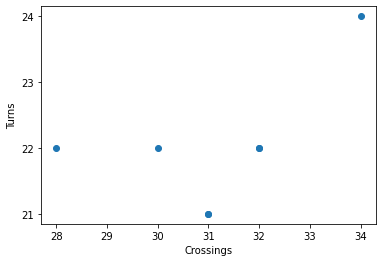

In [8]:
from matplotlib.ticker import MaxNLocator



points = [
    
    (28,22),
(34,24),
(30,22),
(31,21),
(32,22),
(31,21),
(32,22)
]
ax = plt.figure().gca()
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.scatter([n[0] for n in points],[n[1] for n in points])
plt.xlabel('Crossings')
plt.ylabel('Turns')
plt.show()

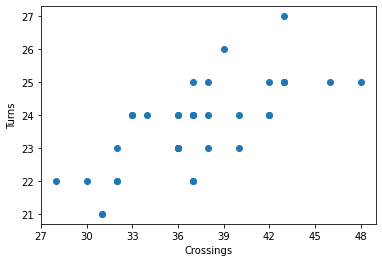

In [9]:
points = [
    
    (42,24),
(37,25),
(43,25),
(43,27),
(36,23),
(33,24),
(37,24),
(39,26),
(32,23),
(37,22),
(36,23),
(38,25),
(40,23),
(38,23),
(37,22),
(28,22),
(34,24),
(30,22),
(31,21),
(32,22),
(31,21),
(32,22),
(36,24),
(36,23),
(33,24),
(46,25),
(42,24),
(43,25),
(38,24),
(36,23),
(37,24),
(48,25),
(42,25),
(43,25),
(40,24),
(36,24),
(37,24)
]
ax = plt.figure().gca()
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.scatter([n[0] for n in points],[n[1] for n in points])
plt.xlabel('Crossings')
plt.ylabel('Turns')
plt.show()

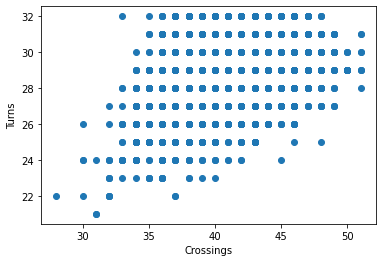

In [10]:
points = [
    
 (45,31),
(43,32),
(47,32),
(46,31),
(42,31),
(41,32),
(47,32),
(40,30),
(36,30),
(45,31),
(39,29),
(43,32),
(43,30),
(42,31),
(45,32),
(43,30),
(37,31),
(36,30),
(46,31),
(41,32),
(43,32),
(40,31),
(43,31),
(44,32),
(46,30),
(42,32),
(44,31),
(43,31),
(41,31),
(45,32),
(39,31),
(43,32),
(44,32),
(46,31),
(46,32),
(43,32),
(47,29),
(44,30),
(48,31),
(48,31),
(49,30),
(46,29),
(44,28),
(41,29),
(48,30),
(44,30),
(42,31),
(44,30),
(39,27),
(40,29),
(37,29),
(38,29),
(39,28),
(40,29),
(37,26),
(32,27),
(36,27),
(38,29),
(36,29),
(42,31),
(41,29),
(41,30),
(45,29),
(42,30),
(41,29),
(42,30),
(41,30),
(38,30),
(43,30),
(42,30),
(40,29),
(39,29),
(42,30),
(43,29),
(43,30),
(41,31),
(43,30),
(45,29),
(43,28),
(40,29),
(40,29),
(38,30),
(42,29),
(40,28),
(38,28),
(37,27),
(42,30),
(41,29),
(45,31),
(45,30),
(45,30),
(43,29),
(40,30),
(45,31),
(43,32),
(47,32),
(46,31),
(42,31),
(47,31),
(40,31),
(42,31),
(38,29),
(45,30),
(38,30),
(42,30),
(42,32),
(37,30),
(40,30),
(41,31),
(46,31),
(45,31),
(43,32),
(45,31),
(42,32),
(44,31),
(43,31),
(41,31),
(45,32),
(41,31),
(45,32),
(44,32),
(46,31),
(46,32),
(43,32),
(45,32),
(45,31),
(43,32),
(44,32),
(42,31),
(44,30),
(40,31),
(41,31),
(45,31),
(41,30),
(40,32),
(46,32),
(40,32),
(44,30),
(42,29),
(39,31),
(45,31),
(39,31),
(47,32),
(43,32),
(44,31),
(40,31),
(41,28),
(39,28),
(41,28),
(44,30),
(46,30),
(45,28),
(41,29),
(42,30),
(43,29),
(43,30),
(43,28),
(41,29),
(42,29),
(40,30),
(40,28),
(38,29),
(39,29),
(43,28),
(43,28),
(40,29),
(41,28),
(40,28),
(43,28),
(41,28),
(44,30),
(44,30),
(43,30),
(42,30),
(41,28),
(39,29),
(41,29),
(44,31),
(40,29),
(38,30),
(45,30),
(39,30),
(40,29),
(40,30),
(41,29),
(36,28),
(35,28),
(41,28),
(38,28),
(46,29),
(43,29),
(46,30),
(45,29),
(41,29),
(42,29),
(38,29),
(43,32),
(43,31),
(41,32),
(42,32),
(42,31),
(44,30),
(40,31),
(41,31),
(43,31),
(43,32),
(44,31),
(39,31),
(38,31),
(44,31),
(41,31),
(46,30),
(44,31),
(45,30),
(42,30),
(39,30),
(45,30),
(42,30),
(45,32),
(41,32),
(44,31),
(40,31),
(41,31),
(45,30),
(43,31),
(41,30),
(43,31),
(45,31),
(45,30),
(41,30),
(40,30),
(43,29),
(43,28),
(38,29),
(34,29),
(40,29),
(43,30),
(37,28),
(41,31),
(40,30),
(44,28),
(35,30),
(41,30),
(34,29),
(44,30),
(45,31),
(41,30),
(45,31),
(39,30),
(43,31),
(37,30),
(46,29),
(45,28),
(42,29),
(46,29),
(36,27),
(40,27),
(39,27),
(42,29),
(35,25),
(30,26),
(34,26),
(36,28),
(42,27),
(42,28),
(37,27),
(39,27),
(41,27),
(39,28),
(38,27),
(39,28),
(46,29),
(45,28),
(42,29),
(43,28),
(41,27),
(38,28),
(45,30),
(45,28),
(42,28),
(41,27),
(38,27),
(36,27),
(35,26),
(42,29),
(41,31),
(45,30),
(43,31),
(41,30),
(43,31),
(45,31),
(47,30),
(45,31),
(44,30),
(42,29),
(43,30),
(41,31),
(42,30),
(36,28),
(43,29),
(36,29),
(42,29),
(42,30),
(41,30),
(45,30),
(35,29),
(38,29),
(44,29),
(44,29),
(42,30),
(44,30),
(45,31),
(41,30),
(45,31),
(39,30),
(45,31),
(39,30),
(45,30),
(45,31),
(43,31),
(44,31),
(42,32),
(44,31),
(40,32),
(41,32),
(41,29),
(45,30),
(40,31),
(46,31),
(40,31),
(44,31),
(42,30),
(39,32),
(45,32),
(39,32),
(47,31),
(43,31),
(44,32),
(40,32),
(41,29),
(39,29),
(41,29),
(39,30),
(43,31),
(44,30),
(46,30),
(39,28),
(43,29),
(37,29),
(41,30),
(45,28),
(41,29),
(38,29),
(42,30),
(42,30),
(43,29),
(47,30),
(42,29),
(44,29),
(44,29),
(42,30),
(46,30),
(43,29),
(43,29),
(40,30),
(41,29),
(40,29),
(43,29),
(41,29),
(44,30),
(44,30),
(43,30),
(39,29),
(39,30),
(40,29),
(42,30),
(41,28),
(39,29),
(41,29),
(35,28),
(34,28),
(40,28),
(37,28),
(44,29),
(43,30),
(42,30),
(47,30),
(45,31),
(43,29),
(41,30),
(40,30),
(46,30),
(41,29),
(45,30),
(46,29),
(37,29),
(41,30),
(43,29),
(46,30),
(44,29),
(42,30),
(43,30),
(43,31),
(42,31),
(42,32),
(44,31),
(40,32),
(41,32),
(43,30),
(43,31),
(44,30),
(39,30),
(38,30),
(44,30),
(41,30),
(46,31),
(44,32),
(45,31),
(42,31),
(39,31),
(45,31),
(42,31),
(43,31),
(45,31),
(44,32),
(40,32),
(39,29),
(38,30),
(41,30),
(37,31),
(41,32),
(42,31),
(37,32),
(46,32),
(40,32),
(38,31),
(43,31),
(38,29),
(43,30),
(35,29),
(37,30),
(40,30),
(38,31),
(43,31),
(38,29),
(41,29),
(37,30),
(40,31),
(45,31),
(46,32),
(39,31),
(43,30),
(37,31),
(42,31),
(38,32),
(43,32),
(40,30),
(43,30),
(40,30),
(42,31),
(38,32),
(37,29),
(38,31),
(38,32),
(43,32),
(42,30),
(37,31),
(42,31),
(43,32),
(35,32),
(42,32),
(39,26),
(42,29),
(46,30),
(46,30),
(38,29),
(40,29),
(40,28),
(47,29),
(44,28),
(46,29),
(38,27),
(38,28),
(40,28),
(37,27),
(39,29),
(43,30),
(37,29),
(38,29),
(40,29),
(36,28),
(39,27),
(41,29),
(42,30),
(45,30),
(39,29),
(42,28),
(40,31),
(41,30),
(42,29),
(42,30),
(38,28),
(41,29),
(40,29),
(41,29),
(37,28),
(35,28),
(42,29),
(40,28),
(38,27),
(42,29),
(37,29),
(43,28),
(39,30),
(40,29),
(35,29),
(36,28),
(40,29),
(36,28),
(45,30),
(46,30),
(42,30),
(43,31),
(42,31),
(39,30),
(38,30),
(42,29),
(43,30),
(39,29),
(43,28),
(39,29),
(41,29),
(41,30),
(39,31),
(41,30),
(42,29),
(44,28),
(40,29),
(42,30),
(43,31),
(45,30),
(43,29),
(37,28),
(42,29),
(41,28),
(40,29),
(39,30),
(35,29),
(42,29),
(41,30),
(37,29),
(41,28),
(40,30),
(41,29),
(42,32),
(44,31),
(41,32),
(48,32),
(39,32),
(48,32),
(40,32),
(44,31),
(40,29),
(44,31),
(49,31),
(41,30),
(43,30),
(42,30),
(46,30),
(40,30),
(41,31),
(48,31),
(40,31),
(38,31),
(40,32),
(41,31),
(38,32),
(45,32),
(39,32),
(39,31),
(42,31),
(41,30),
(46,31),
(40,31),
(44,30),
(39,31),
(38,31),
(43,31),
(37,31),
(44,32),
(39,31),
(38,31),
(46,32),
(43,32),
(42,30),
(44,29),
(40,30),
(39,30),
(44,31),
(37,30),
(41,31),
(44,31),
(45,31),
(39,31),
(41,30),
(38,32),
(41,32),
(39,31),
(42,31),
(41,31),
(42,31),
(42,30),
(45,30),
(42,32),
(42,31),
(41,31),
(39,32),
(39,30),
(39,32),
(44,32),
(43,31),
(46,31),
(39,31),
(39,32),
(42,32),
(44,30),
(39,30),
(38,31),
(44,31),
(45,31),
(39,31),
(44,32),
(43,31),
(42,32),
(36,32),
(41,32),
(40,30),
(38,31),
(40,30),
(41,31),
(39,32),
(41,31),
(39,30),
(37,31),
(41,31),
(41,32),
(41,31),
(39,31),
(38,29),
(42,29),
(42,30),
(40,30),
(37,31),
(43,31),
(43,31),
(39,30),
(43,30),
(43,31),
(41,31),
(38,32),
(44,32),
(44,32),
(43,29),
(40,31),
(43,30),
(41,30),
(41,31),
(42,32),
(40,32),
(40,31),
(41,32),
(41,32),
(42,31),
(38,31),
(42,31),
(43,32),
(39,32),
(43,32),
(37,31),
(41,32),
(39,32),
(42,29),
(41,28),
(41,29),
(41,29),
(44,30),
(44,29),
(43,28),
(44,30),
(45,29),
(41,27),
(39,27),
(38,29),
(39,28),
(37,29),
(37,30),
(37,28),
(35,28),
(43,30),
(42,29),
(42,30),
(42,30),
(45,31),
(45,30),
(44,29),
(45,31),
(46,30),
(42,28),
(40,28),
(39,30),
(40,29),
(43,29),
(40,30),
(41,29),
(41,30),
(41,28),
(39,28),
(41,29),
(43,29),
(39,28),
(44,29),
(39,28),
(41,27),
(39,29),
(38,29),
(37,28),
(37,29),
(36,28),
(42,30),
(44,30),
(40,29),
(45,30),
(40,29),
(42,28),
(42,30),
(41,31),
(40,29),
(40,30),
(39,30),
(43,29),
(37,30),
(44,30),
(39,30),
(42,29),
(41,30),
(43,29),
(42,28),
(39,28),
(42,29),
(37,30),
(35,29),
(44,30),
(43,29),
(40,29),
(43,30),
(41,30),
(39,29),
(42,30),
(40,30),
(40,30),
(39,31),
(41,31),
(43,30),
(42,30),
(42,29),
(39,31),
(42,30),
(42,30),
(40,31),
(42,30),
(42,31),
(42,31),
(43,31),
(42,30),
(45,32),
(45,31),
(44,30),
(42,30),
(40,30),
(45,32),
(46,31),
(39,32),
(40,31),
(40,31),
(38,32),
(40,31),
(38,30),
(36,31),
(38,31),
(38,32),
(38,31),
(36,31),
(42,30),
(42,30),
(39,31),
(38,32),
(43,32),
(43,31),
(41,31),
(44,32),
(44,32),
(42,31),
(44,31),
(40,31),
(40,31),
(45,32),
(42,30),
(38,31),
(42,31),
(42,32),
(40,31),
(37,31),
(43,31),
(43,31),
(42,30),
(39,30),
(40,31),
(38,31),
(38,32),
(39,31),
(37,31),
(42,31),
(43,30),
(42,31),
(44,31),
(40,32),
(38,32),
(40,30),
(44,31),
(40,31),
(44,31),
(43,31),
(44,31),
(40,31),
(43,32),
(42,32),
(38,32),
(42,32),
(36,31),
(38,32),
(36,32),
(41,29),
(39,29),
(41,29),
(39,30),
(37,29),
(37,29),
(39,31),
(42,30),
(40,30),
(37,31),
(44,31),
(38,30),
(39,29),
(39,29),
(36,27),
(41,27),
(38,28),
(36,28),
(33,28),
(39,28),
(44,30),
(41,30),
(38,28),
(41,28),
(39,29),
(35,29),
(41,29),
(37,29),
(41,28),
(39,28),
(40,29),
(40,29),
(44,31),
(38,30),
(40,30),
(41,30),
(41,29),
(35,28),
(41,28),
(42,31),
(36,30),
(42,30),
(36,30),
(41,30),
(37,30),
(44,28),
(43,27),
(44,28),
(42,28),
(41,29),
(43,29),
(44,28),
(43,29),
(41,26),
(40,25),
(42,26),
(36,24),
(36,25),
(40,27),
(40,27),
(41,28),
(38,27),
(35,27),
(34,26),
(33,26),
(43,27),
(44,29),
(42,26),
(41,28),
(38,25),
(37,27),
(42,28),
(44,28),
(42,28),
(41,27),
(39,27),
(43,29),
(41,29),
(41,29),
(37,28),
(35,28),
(43,29),
(43,29),
(39,28),
(40,28),
(39,27),
(42,30),
(43,26),
(42,26),
(36,25),
(40,27),
(38,27),
(34,26),
(44,28),
(43,28),
(40,28),
(37,27),
(36,27),
(41,29),
(43,28),
(41,28),
(47,30),
(43,30),
(43,29),
(41,30),
(41,30),
(46,30),
(39,28),
(39,29),
(44,31),
(41,30),
(40,31),
(46,30),
(40,31),
(41,30),
(39,30),
(38,31),
(43,31),
(37,30),
(45,28),
(42,31),
(40,27),
(44,26),
(40,26),
(41,28),
(44,28),
(38,28),
(37,28),
(39,28),
(44,29),
(39,29),
(44,29),
(42,30),
(43,31),
(41,30),
(39,29),
(40,29),
(38,29),
(35,29),
(41,29),
(37,29),
(39,28),
(37,28),
(46,30),
(46,30),
(41,29),
(42,28),
(42,29),
(43,29),
(43,31),
(45,31),
(43,31),
(37,30),
(39,30),
(40,30),
(43,30),
(45,30),
(39,29),
(37,29),
(43,29),
(44,29),
(38,29),
(42,31),
(43,31),
(37,30),
(43,30),
(37,30),
(40,30),
(36,30),
(41,30),
(39,31),
(41,30),
(43,31),
(43,31),
(41,32),
(41,31),
(39,32),
(43,30),
(43,30),
(41,30),
(43,31),
(39,29),
(43,29),
(43,30),
(41,30),
(38,31),
(44,31),
(44,31),
(41,30),
(45,30),
(45,30),
(45,29),
(43,29),
(45,31),
(43,30),
(43,31),
(46,32),
(40,32),
(46,32),
(42,32),
(44,31),
(42,31),
(41,31),
(43,31),
(43,32),
(43,31),
(39,31),
(43,31),
(45,32),
(41,32),
(45,32),
(39,32),
(43,31),
(41,31),
(43,29),
(42,28),
(42,29),
(42,29),
(45,30),
(45,29),
(44,28),
(45,30),
(46,29),
(42,27),
(40,27),
(39,29),
(40,28),
(38,29),
(38,30),
(38,28),
(36,28),
(44,29),
(44,30),
(45,30),
(47,30),
(46,29),
(44,30),
(44,30),
(45,30),
(42,31),
(48,30),
(46,31),
(47,31),
(40,29),
(40,29),
(44,28),
(42,28),
(42,29),
(40,30),
(41,30),
(43,29),
(42,29),
(44,29),
(40,28),
(45,29),
(40,28),
(42,27),
(40,29),
(39,29),
(38,28),
(38,29),
(37,28),
(44,30),
(46,30),
(47,30),
(42,29),
(44,28),
(42,29),
(44,29),
(38,30),
(41,31),
(44,30),
(44,30),
(43,31),
(47,31),
(46,30),
(42,30),
(42,29),
(41,30),
(47,30),
(44,31),
(43,29),
(41,30),
(40,30),
(44,29),
(43,28),
(40,28),
(43,29),
(38,30),
(36,29),
(44,30),
(46,30),
(45,29),
(45,30),
(40,29),
(42,29),
(45,30),
(44,31),
(44,30),
(40,30),
(42,31),
(40,30),
(44,30),
(42,31),
(41,32),
(45,30),
(47,31),
(43,32),
(47,30),
(45,31),
(43,30),
(44,31),
(45,30),
(44,30),
(46,29),
(44,29),
(47,31),
(45,32),
(46,30),
(42,31),
(45,31),
(41,32),
(47,31),
(40,31),
(44,31),
(48,30),
(40,32),
(43,32),
(44,31),
(42,31),
(42,31),
(40,31),
(40,30),
(40,30),
(38,30),
(40,32),
(38,32),
(40,31),
(44,31),
(44,30),
(44,31),
(42,30),
(46,30),
(42,30),
(47,31),
(44,29),
(40,31),
(44,31),
(44,31),
(42,30),
(40,30),
(44,32),
(40,31),
(42,31),
(45,31),
(39,31),
(45,31),
(41,31),
(41,30),
(39,30),
(46,30),
(44,32),
(44,31),
(43,31),
(45,31),
(43,30),
(45,31),
(46,32),
(40,31),
(42,32),
(44,31),
(41,32),
(44,31),
(47,32),
(47,32),
(46,32),
(48,31),
(45,30),
(45,32),
(40,30),
(42,31),
(46,30),
(47,31),
(44,31),
(45,31),
(44,32),
(40,32),
(44,32),
(38,32),
(40,31),
(38,31),
(43,30),
(45,30),
(43,30),
(47,30),
(51,31),
(45,31),
(47,30),
(44,29),
(48,30),
(44,30),
(44,30),
(41,31),
(49,31),
(38,30),
(46,29),
(43,30),
(50,30),
(45,31),
(51,31),
(46,29),
(49,30),
(43,28),
(44,29),
(47,29),
(43,29),
(48,30),
(44,30),
(47,29),
(46,28),
(48,29),
(44,29),
(46,31),
(47,31),
(44,30),
(48,31),
(48,31),
(48,30),
(41,29),
(47,30),
(43,30),
(43,27),
(41,27),
(38,27),
(46,28),
(43,28),
(47,29),
(41,28),
(40,28),
(44,29),
(38,28),
(46,28),
(50,29),
(50,29),
(42,28),
(44,28),
(44,28),
(51,29),
(48,28),
(50,29),
(42,27),
(42,28),
(46,28),
(44,28),
(40,27),
(41,28),
(37,27),
(41,30),
(47,29),
(48,29),
(43,28),
(44,27),
(44,28),
(45,28),
(41,27),
(39,27),
(46,28),
(45,29),
(44,29),
(41,28),
(40,28),
(40,28),
(37,26),
(36,27),
(44,29),
(42,27),
(45,29),
(41,28),
(37,27),
(47,29),
(43,29),
(40,29),
(45,28),
(43,28),
(45,28),
(44,28),
(41,28),
(47,28),
(41,27),
(46,28),
(43,28),
(39,27),
(40,28),
(36,27),
(45,28),
(41,30),
(41,30),
(41,30),
(43,30),
(47,31),
(41,31),
(45,30),
(42,29),
(44,30),
(40,30),
(42,30),
(47,30),
(38,31),
(44,29),
(46,30),
(47,30),
(47,29),
(44,30),
(41,29),
(40,29),
(43,30),
(39,30),
(45,30),
(40,30),
(44,31),
(43,31),
(42,30),
(46,31),
(44,31),
(46,30),
(39,29),
(43,30),
(39,30),
(45,29),
(48,30),
(41,28),
(44,29),
(41,29),
(42,29),
(46,30),
(46,28),
(40,27),
(36,27),
(41,27),
(38,28),
(43,28),
(42,27),
(37,27),
(43,26),
(39,26),
(47,30),
(42,28),
(44,28),
(45,30),
(46,30),
(45,28),
(38,28),
(45,28),
(39,28),
(45,26),
(42,27),
(46,27),
(46,27),
(37,26),
(43,28),
(41,24),
(34,25),
(40,25),
(40,27),
(35,23),
(30,24),
(34,24),
(36,26),
(40,25),
(41,26),
(41,26),
(40,26),
(44,27),
(41,28),
(41,26),
(39,25),
(36,26),
(45,28),
(45,28),
(41,27),
(40,26),
(44,26),
(40,26),
(39,25),
(36,25),
(34,25),
(33,24),
(42,27),
(44,27),
(43,29),
(46,30),
(39,28),
(42,29),
(41,29),
(43,30),
(43,28),
(41,27),
(36,27),
(40,26),
(36,26),
(39,27),
(44,27),
(36,27),
(43,28),
(44,28),
(44,29),
(45,30),
(40,28),
(42,28),
(45,30),
(44,30),
(45,28),
(38,28),
(43,28),
(37,28),
(43,31),
(45,29),
(47,29),
(43,31),
(45,30),
(51,30),
(47,30),
(44,30),
(48,29),
(44,29),
(44,30),
(37,30),
(41,31),
(49,31),
(46,30),
(50,29),
(43,31),
(45,30),
(51,30),
(46,29),
(43,29),
(47,28),
(43,28),
(49,30),
(44,30),
(48,29),
(44,29),
(47,29),
(46,29),
(48,28),
(44,28),
(47,30),
(46,31),
(44,31),
(48,31),
(48,30),
(48,30),
(41,30),
(47,29),
(43,29),
(37,27),
(41,28),
(43,27),
(39,28),
(43,29),
(46,29),
(43,29),
(47,30),
(37,28),
(41,29),
(42,28),
(49,28),
(46,27),
(46,28),
(44,29),
(50,29),
(50,29),
(42,28),
(44,28),
(51,29),
(40,28),
(44,29),
(48,28),
(46,29),
(50,29),
(36,27),
(40,28),
(42,27),
(42,28),
(42,28),
(43,27),
(44,28),
(45,28),
(39,28),
(41,27),
(36,26),
(39,27),
(35,27),
(46,28),
(44,29),
(42,27),
(36,27),
(39,29),
(43,30),
(47,29),
(45,29),
(48,29),
(43,29),
(43,28),
(42,28),
(45,29),
(43,28),
(44,30),
(48,29),
(47,29),
(46,29),
(45,29),
(40,28),
(39,28),
(48,29),
(42,28),
(40,28),
(44,29),
(39,28),
(43,29),
(47,28),
(35,27),
(39,28),
(41,27),
(46,28),
(45,28),
(41,31),
(43,29),
(41,30),
(41,31),
(47,30),
(42,30),
(44,29),
(47,30),
(42,30),
(44,30),
(46,29),
(47,29),
(47,29),
(40,28),
(44,30),
(41,30),
(43,29),
(39,29),
(45,30),
(40,29),
(43,30),
(42,31),
(41,31),
(44,30),
(39,30),
(43,29),
(42,30),
(42,32),
(41,31),
(44,31),
(41,30),
(36,30),
(46,31),
(37,30),
(43,31),
(40,32),
(42,32),
(41,31),
(40,31),
(43,31),
(41,32),
(46,32),
(41,30),
(44,30),
(43,31),
(43,32),
(40,31),
(44,32),
(45,31),
(40,32),
(45,32),
(38,27),
(39,27),
(42,27),
(40,29),
(41,29),
(44,30),
(45,30),
(38,29),
(39,29),
(45,29),
(45,30),
(49,31),
(49,31),
(41,30),
(43,30),
(43,29),
(50,30),
(47,29),
(42,29),
(41,29),
(49,30),
(37,28),
(38,28),
(41,28),
(41,29),
(43,29),
(43,29),
(39,31),
(45,30),
(40,27),
(44,28),
(41,29),
(46,30),
(43,30),
(44,30),
(40,30),
(43,31),
(42,31),
(38,29),
(37,28),
(39,29),
(40,29),
(36,29),
(38,29),
(45,30),
(39,30),
(38,30),
(43,30),
(43,30),
(38,28),
(37,28),
(39,29),
(41,28),
(39,29),
(41,29),
(40,29),
(46,29),
(44,30),
(42,31),
(42,30),
(41,29),
(39,30),
(41,29),
(41,29),
(42,29),
(46,30),
(41,30),
(40,30),
(36,29),
(37,29),
(40,29),
(45,30),
(44,29),
(40,30),
(40,32),
(39,31),
(44,31),
(36,30),
(46,30),
(36,31),
(40,31),
(41,31),
(38,32),
(43,32),
(43,31),
(41,32),
(40,31),
(44,32),
(45,31),
(38,32),
(45,32),
(43,31),
(43,30),
(41,31),
(42,31),
(41,29),
(45,30),
(38,31),
(46,31),
(40,31),
(45,31),
(41,31),
(40,28),
(40,28),
(40,28),
(42,27),
(44,27),
(41,28),
(40,28),
(39,28),
(40,28),
(42,28),
(41,31),
(41,30),
(39,31),
(40,31),
(43,30),
(43,31),
(44,30),
(39,30),
(38,30),
(44,30),
(41,30),
(43,31),
(39,31),
(44,30),
(44,30),
(42,31),
(42,31),
(40,30),
(42,30),
(40,30),
(41,30),
(39,28),
(44,28),
(39,29),
(34,29),
(40,29),
(38,30),
(42,30),
(35,29),
(43,30),
(44,31),
(38,30),
(43,29),
(42,29),
(47,29),
(47,29),
(42,27),
(44,28),
(42,28),
(44,29),
(45,27),
(43,28),
(39,27),
(41,27),
(41,28),
(37,29),
(35,26),
(39,26),
(37,26),
(39,27),
(37,27),
(35,28),
(43,28),
(41,27),
(43,28),
(43,29),
(42,29),
(47,29),
(39,28),
(38,28),
(44,28),
(46,30),
(42,30),
(44,30),
(42,31),
(40,31),
(40,30),
(40,30),
(44,30),
(42,31),
(40,31),
(34,29),
(37,29),
(39,29),
(44,29),
(34,30),
(40,30),
(43,30),
(43,30),
(44,31),
(38,30),
(43,31),
(41,32),
(43,32),
(42,32),
(41,30),
(45,31),
(38,32),
(46,32),
(40,32),
(45,32),
(41,32),
(44,30),
(47,31),
(40,30),
(40,31),
(44,30),
(44,30),
(46,31),
(42,28),
(40,29),
(38,29),
(40,29),
(44,28),
(40,29),
(40,29),
(41,29),
(40,30),
(40,29),
(39,29),
(40,29),
(42,29),
(44,30),
(43,31),
(40,31),
(47,31),
(44,30),
(40,31),
(45,30),
(40,29),
(38,30),
(41,31),
(41,32),
(40,32),
(43,31),
(43,32),
(44,31),
(39,31),
(38,31),
(44,31),
(41,31),
(41,32),
(43,32),
(47,31),
(44,31),
(43,32),
(43,32),
(42,31),
(43,32),
(45,30),
(42,30),
(47,31),
(47,31),
(45,30),
(42,30),
(40,30),
(43,29),
(45,31),
(42,31),
(43,32),
(43,31),
(45,32),
(44,31),
(43,30),
(46,31),
(41,31),
(40,30),
(48,31),
(43,31),
(44,31),
(41,32),
(43,32),
(47,32),
(40,31),
(44,31),
(44,32),
(42,29),
(43,31),
(43,30),
(41,29),
(42,29),
(42,29),
(43,29),
(40,28),
(39,27),
(42,30),
(43,29),
(40,29),
(44,30),
(42,31),
(44,31),
(44,29),
(42,30),
(40,30),
(40,30),
(39,29),
(40,29),
(39,29),
(40,30),
(41,31),
(42,31),
(40,28),
(39,28),
(43,30),
(39,29),
(40,29),
(39,28),
(38,28),
(42,28),
(41,26),
(36,27),
(42,27),
(40,29),
(41,27),
(42,28),
(45,28),
(42,27),
(38,27),
(39,26),
(42,29),
(44,30),
(46,30),
(42,28),
(46,29),
(44,30),
(42,27),
(46,28),
(41,28),
(39,28),
(43,29),
(41,28),
(36,29),
(43,31),
(42,29),
(44,31),
(40,31),
(44,31),
(39,30),
(47,30),
(44,29),
(48,30),
(45,29),
(42,27),
(46,29),
(43,30),
(39,29),
(42,29),
(45,31),
(41,30),
(42,30),
(40,30),
(39,30),
(43,30),
(47,31),
(41,30),
(42,31),
(42,30),
(45,31),
(44,30),
(42,31),
(44,31),
(42,29),
(42,29),
(41,30),
(39,29),
(39,30),
(46,31),
(42,31),
(45,31),
(41,30),
(45,31),
(43,30),
(41,31),
(44,32),
(47,32),
(43,32),
(43,32),
(42,31),
(42,32),
(42,32),
(45,31),
(41,31),
(43,30),
(47,31),
(42,29),
(40,30),
(47,31),
(45,30),
(45,30),
(45,32),
(40,31),
(45,31),
(45,32),
(44,32),
(43,30),
(42,31),
(45,30),
(41,30),
(45,30),
(42,30),
(44,30),
(46,31),
(45,31),
(41,31),
(48,32),
(44,31),
(47,31),
(45,32),
(43,32),
(44,31),
(44,32),
(46,31),
(44,30),
(42,31),
(46,31),
(42,31),
(46,32),
(46,32),
(42,32),
(44,32),
(44,32),
(45,30),
(43,29),
(41,30),
(45,30),
(41,30),
(43,31),
(43,31),
(41,31),
(43,31),
(43,31),
(44,29),
(42,30),
(42,30),
(42,29),
(41,29),
(42,28),
(42,29),
(41,29),
(42,29),
(43,29),
(39,28),
(44,31),
(45,31),
(42,30),
(44,31),
(42,31),
(44,30),
(43,30),
(42,30),
(39,30),
(40,29),
(38,29),
(42,29),
(41,30),
(41,29),
(44,30),
(44,30),
(44,31),
(42,29),
(43,28),
(43,29),
(41,30),
(41,29),
(46,30),
(42,30),
(42,30),
(42,30),
(44,30),
(43,31),
(41,31),
(41,30),
(40,29),
(41,29),
(41,27),
(40,29),
(44,29),
(44,29),
(38,30),
(41,30),
(40,30),
(40,29),
(39,29),
(39,30),
(41,30),
(37,29),
(37,29),
(41,29),
(41,29),
(38,29),
(38,28),
(42,30),
(39,29),
(44,29),
(42,28),
(42,31),
(42,32),
(44,32),
(40,32),
(40,32),
(44,32),
(44,32),
(41,32),
(41,31),
(43,30),
(43,31),
(43,31),
(41,31),
(41,31),
(43,31),
(45,31),
(42,31),
(42,30),
(46,30),
(42,31),
(42,29),
(43,30),
(40,29),
(41,30),
(42,30),
(43,31),
(44,30),
(45,29),
(40,29),
(45,29),
(40,29),
(43,28),
(44,29),
(46,30),
(43,30),
(41,31),
(40,30),
(44,31),
(46,29),
(43,29),
(42,29),
(41,30),
(40,29),
(42,28),
(41,28),
(42,29),
(38,27),
(37,25),
(38,26),
(40,28),
(40,28),
(40,28),
(39,28),
(44,29),
(36,27),
(40,29),
(42,27),
(41,26),
(43,29),
(44,29),
(38,28),
(39,28),
(42,28),
(44,29),
(46,30),
(44,27),
(43,28),
(41,28),
(46,29),
(44,28),
(41,29),
(41,28),
(40,28),
(44,29),
(44,28),
(41,29),
(45,30),
(36,27),
(40,29),
(42,27),
(41,26),
(40,27),
(39,27),
(43,29),
(37,28),
(38,28),
(40,28),
(40,28),
(40,27),
(42,29),
(42,28),
(42,29),
(39,27),
(40,26),
(39,27),
(37,27),
(42,29),
(44,29),
(43,28),
(42,29),
(44,29),
(41,29),
(42,29),
(39,28),
(42,28),
(44,28),
(42,29),
(41,28),
(37,27),
(38,28),
(40,27),
(41,29),
(41,28),
(40,29),
(43,30),
(42,31),
(40,29),
(43,30),
(40,30),
(45,31),
(42,31),
(42,28),
(40,29),
(45,29),
(39,30),
(43,29),
(40,30),
(40,30),
(41,30),
(45,30),
(42,31),
(46,30),
(46,31),
(44,31),
(44,31),
(41,29),
(45,29),
(43,29),
(42,29),
(44,30),
(42,30),
(46,30),
(43,30),
(44,30),
(42,30),
(46,31),
(46,31),
(43,30),
(44,31),
(45,31),
(43,30),
(41,31),
(45,31),
(41,31),
(43,32),
(43,32),
(41,32),
(43,32),
(43,32),
(44,30),
(42,31),
(42,31),
(42,30),
(41,30),
(42,29),
(42,30),
(41,30),
(42,30),
(43,30),
(39,29),
(44,31),
(46,31),
(38,29),
(42,30),
(44,30),
(38,30),
(40,30),
(44,31),
(44,31),
(42,30),
(44,31),
(45,31),
(36,29),
(36,29),
(43,29),
(40,30),
(40,30),
(42,29),
(44,29),
(40,29),
(44,30),
(44,30),
(40,29),
(44,30),
(43,30),
(43,29),
(37,29),
(42,30),
(39,30),
(40,29),
(38,29),
(43,28),
(37,28),
(44,30),
(41,30),
(40,29),
(44,30),
(41,29),
(43,28),
(41,30),
(43,29),
(43,30),
(45,30),
(43,30),
(45,30),
(44,30),
(45,29),
(44,30),
(42,31),
(39,30),
(44,30),
(42,29),
(43,31),
(43,32),
(43,32),
(41,32),
(41,32),
(43,32),
(45,32),
(42,32),
(42,31),
(38,28),
(41,29),
(38,29),
(39,28),
(41,30),
(41,30),
(38,29),
(37,29),
(38,30),
(39,30),
(38,31),
(41,31),
(38,30),
(43,31),
(40,30),
(39,30),
(42,31),
(43,30),
(41,31),
(41,30),
(40,31),
(42,31),
(41,30),
(42,30),
(45,31),
(44,31),
(38,31),
(41,31),
(39,32),
(38,31),
(39,31),
(38,32),
(40,31),
(40,32),
(40,32),
(38,31),
(41,31),
(41,32),
(44,32),
(42,32),
(41,30),
(39,31),
(41,30),
(39,31),
(38,31),
(41,31),
(38,32),
(41,32),
(38,28),
(38,27),
(40,28),
(40,29),
(42,29),
(40,27),
(42,28),
(40,27),
(36,26),
(38,28),
(40,30),
(39,30),
(39,29),
(40,29),
(40,29),
(38,29),
(38,29),
(40,28),
(43,30),
(39,29),
(40,29),
(43,30),
(42,30),
(43,30),
(39,29),
(35,28),
(36,29),
(41,29),
(34,28),
(39,29),
(38,30),
(37,30),
(37,29),
(38,29),
(40,29),
(36,27),
(38,29),
(39,29),
(37,30),
(42,30),
(38,28),
(38,29),
(41,29),
(35,29),
(41,29),
(37,29),
(39,28),
(37,29),
(38,29),
(36,30),
(38,30),
(38,29),
(36,29),
(36,28),
(39,29),
(42,29),
(39,27),
(38,27),
(39,29),
(41,29),
(40,29),
(39,30),
(40,30),
(42,29),
(41,31),
(41,31),
(40,29),
(38,31),
(40,31),
(42,29),
(38,30),
(44,30),
(41,29),
(45,30),
(43,30),
(40,28),
(44,30),
(41,31),
(41,30),
(39,29),
(37,28),
(39,29),
(42,30),
(43,29),
(40,29),
(39,29),
(38,27),
(40,30),
(39,30),
(37,29),
(41,29),
(41,28),
(40,29),
(39,29),
(37,31),
(41,30),
(40,30),
(39,31),
(41,31),
(39,31),
(38,31),
(40,30),
(39,31),
(41,30),
(37,29),
(38,29),
(37,30),
(37,30),
(37,30),
(38,29),
(37,30),
(39,31),
(38,31),
(38,30),
(39,30),
(42,28),
(42,31),
(38,31),
(41,29),
(40,31),
(40,29),
(40,28),
(39,31),
(41,31),
(39,30),
(44,30),
(39,30),
(42,31),
(44,31),
(41,29),
(43,30),
(43,30),
(43,30),
(43,30),
(39,31),
(40,30),
(39,30),
(42,31),
(40,30),
(42,31),
(44,31),
(42,29),
(44,30),
(42,30),
(38,29),
(40,32),
(38,31),
(40,30),
(42,32),
(39,32),
(37,31),
(39,32),
(38,32),
(41,32),
(42,31),
(38,32),
(42,30),
(40,31),
(40,30),
(42,30),
(42,31),
(40,31),
(39,31),
(37,31),
(41,32),
(40,32),
(38,31),
(39,31),
(43,31),
(40,32),
(44,31),
(44,32),
(44,32),
(43,31),
(43,31),
(42,32),
(42,32),
(45,32),
(41,31),
(41,32),
(37,31),
(41,32),
(41,31),
(42,31),
(42,31),
(45,32),
(38,32),
(43,32),
(39,32),
(39,32),
(42,32),
(40,32),
(44,32),
(36,31),
(45,32),
(41,32),
(39,31),
(42,31),
(41,30),
(39,30),
(41,32),
(42,31),
(40,32),
(42,31),
(41,32),
(43,32),
(40,31),
(41,31),
(44,32),
(43,32),
(35,31),
(40,31),
(38,32),
(39,31),
(38,31),
(37,32),
(41,31),
(39,32),
(39,32),
(39,31),
(40,31),
(42,31),
(43,31),
(41,31),
(39,30),
(39,31),
(39,30),
(39,31),
(39,32),
(40,32),
(39,31),
(40,31),
(37,30),
(37,30),
(41,30),
(38,30),
(39,30),
(39,31),
(39,31),
(38,30),
(39,31),
(38,31),
(38,31),
(42,31),
(39,31),
(40,31),
(40,32),
(40,32),
(39,31),
(40,32),
(40,30),
(40,30),
(39,31),
(39,31),
(36,32),
(39,31),
(40,31),
(40,30),
(40,31),
(40,30),
(40,31),
(38,32),
(38,29),
(39,29),
(38,30),
(40,29),
(39,30),
(39,30),
(38,30),
(38,30),
(40,30),
(40,28),
(40,29),
(39,30),
(37,29),
(40,29),
(41,30),
(40,30),
(41,30),
(40,28),
(38,27),
(37,29),
(41,29),
(36,29),
(35,28),
(39,29),
(36,28),
(36,30),
(36,29),
(36,30),
(36,28),
(36,29),
(34,28),
(39,30),
(40,30),
(39,31),
(41,30),
(40,31),
(40,31),
(39,31),
(39,31),
(41,31),
(41,29),
(41,30),
(40,31),
(38,30),
(41,30),
(42,31),
(41,31),
(42,31),
(41,29),
(39,28),
(38,30),
(42,30),
(37,30),
(36,29),
(40,30),
(37,29),
(37,30),
(40,29),
(36,30),
(39,30),
(38,30),
(40,30),
(40,31),
(40,31),
(40,28),
(36,29),
(38,30),
(38,30),
(40,30),
(40,29),
(40,30),
(40,28),
(38,29),
(40,29),
(37,30),
(37,30),
(38,31),
(39,31),
(41,31),
(41,30),
(39,31),
(38,31),
(38,30),
(41,30),
(43,30),
(40,31),
(39,31),
(39,31),
(42,31),
(39,31),
(39,32),
(41,31),
(41,31),
(40,31),
(43,32),
(41,32),
(43,32),
(43,32),
(39,31),
(39,31),
(41,31),
(41,30),
(43,31),
(41,31),
(41,31),
(41,31),
(43,31),
(37,32),
(38,31),
(37,31),
(38,32),
(40,32),
(38,32),
(40,32),
(39,32),
(39,31),
(39,32),
(40,31),
(40,32),
(41,31),
(39,32),
(41,32),
(41,30),
(41,31),
(40,32),
(38,31),
(41,31),
(42,32),
(41,32),
(42,32),
(41,31),
(39,30),
(38,32),
(36,31),
(37,32),
(42,32),
(37,31),
(40,32),
(37,32),
(37,32),
(41,32),
(38,32),
(39,32),
(39,32),
(39,32),
(38,31),
(39,31),
(39,31),
(39,31),
(38,32),
(38,31),
(33,32),
(37,31),
(37,32),
(37,31),
(37,32),
(37,31),
(37,32),
(35,31),
(40,29),
(38,30),
(36,27),
(36,28),
(39,29),
(39,27),
(36,28),
(37,28),
(40,30),
(41,30),
(43,30),
(38,31),
(40,30),
(39,30),
(43,30),
(41,31),
(36,31),
(39,31),
(36,29),
(40,29),
(41,28),
(39,29),
(41,28),
(41,28),
(42,28),
(42,29),
(43,29),
(38,29),
(37,30),
(37,30),
(40,30),
(40,29),
(37,29),
(39,29),
(36,29),
(37,29),
(39,29),
(39,28),
(42,28),
(40,27),
(40,25),
(38,26),
(41,29),
(40,27),
(40,27),
(40,28),
(39,29),
(38,26),
(40,25),
(39,26),
(39,27),
(36,26),
(38,27),
(36,25),
(38,25),
(42,26),
(40,27),
(38,26),
(38,28),
(34,24),
(34,24),
(34,25),
(37,26),
(36,27),
(38,26),
(36,28),
(40,27),
(38,28),
(40,28),
(36,26),
(36,27),
(36,27),
(40,29),
(38,28),
(38,29),
(40,28),
(38,27),
(39,27),
(40,28),
(36,27),
(34,26),
(34,25),
(33,26),
(35,27),
(36,27),
(34,28),
(41,29),
(43,29),
(42,29),
(41,27),
(40,27),
(39,29),
(40,29),
(42,28),
(41,29),
(41,29),
(41,29),
(40,30),
(40,27),
(39,28),
(41,27),
(41,27),
(40,28),
(40,29),
(36,28),
(38,26),
(37,28),
(39,27),
(39,29),
(41,28),
(37,28),
(39,28),
(39,28),
(36,29),
(40,28),
(42,28),
(41,29),
(43,28),
(35,27),
(36,25),
(36,26),
(35,26),
(37,28),
(37,27),
(38,27),
(37,28),
(39,27),
(38,29),
(38,27),
(36,27),
(40,26),
(37,29),
(42,29),
(41,30),
(39,30),
(41,29),
(37,28),
(38,28),
(42,31),
(39,29),
(44,31),
(43,30),
(44,28),
(42,30),
(41,30),
(40,30),
(39,31),
(40,29),
(42,31),
(44,29),
(41,31),
(42,31),
(40,31),
(41,31),
(43,31),
(38,29),
(35,28),
(39,29),
(40,27),
(40,30),
(36,30),
(38,27),
(38,26),
(40,26),
(35,28),
(41,29),
(42,27),
(38,29),
(41,28),
(37,28),
(41,28),
(40,28),
(36,28),
(42,28),
(40,28),
(42,30),
(42,30),
(38,29),
(42,28),
(43,28),
(44,29),
(44,28),
(38,30),
(39,29),
(37,29),
(38,29),
(40,29),
(40,28),
(39,30),
(37,29),
(42,30),
(41,28),
(40,29),
(36,28),
(40,28),
(39,29),
(38,29),
(40,30),
(37,30),
(39,30),
(42,30),
(40,30),
(42,29),
(39,31),
(41,31),
(42,30),
(38,30),
(41,31),
(40,31),
(42,31),
(37,31),
(41,30),
(39,30),
(42,31),
(40,31),
(37,31),
(38,31),
(37,30),
(39,30),
(40,29),
(38,30),
(40,29),
(42,29),
(41,29),
(43,30),
(42,30),
(39,30),
(36,30),
(38,30),
(39,30),
(41,29),
(36,29),
(38,29),
(37,29),
(36,29),
(39,29),
(37,28),
(38,30),
(38,30),
(42,30),
(39,30),
(40,30),
(40,31),
(40,31),
(39,30),
(40,31),
(40,31),
(42,30),
(42,31),
(42,30),
(44,31),
(44,31),
(42,29),
(42,29),
(42,30),
(42,31),
(42,30),
(40,31),
(42,32),
(42,32),
(41,31),
(42,32),
(42,32),
(40,31),
(39,29),
(40,29),
(39,30),
(41,29),
(40,30),
(40,30),
(39,30),
(39,30),
(41,30),
(41,28),
(41,29),
(40,30),
(38,29),
(41,29),
(42,30),
(41,30),
(42,30),
(41,28),
(39,27),
(38,29),
(42,29),
(37,29),
(36,28),
(40,29),
(37,28),
(37,30),
(37,29),
(37,30),
(37,28),
(37,29),
(35,28),
(41,30),
(41,31),
(41,31),
(43,30),
(39,31),
(42,30),
(38,31),
(41,31),
(40,31),
(40,30),
(40,29),
(38,29),
(42,30),
(43,29),
(41,30),
(40,30),
(40,30),
(41,29),
(41,28),
(38,29),
(39,29),
(40,29),
(39,30),
(40,29),
(38,30),
(42,31),
(41,31),
(40,32),
(38,30),
(41,31),
(42,31),
(43,31),
(43,32),
(43,29),
(43,30),
(42,30),
(43,31),
(41,32),
(43,32),
(43,31),
(41,32),
(40,32),
(40,31),
(42,31),
(40,30),
(45,32),
(42,31),
(39,31),
(43,30),
(43,31),
(41,30),
(44,31),
(42,30),
(45,31),
(44,31),
(42,32),
(40,31),
(43,31),
(41,32),
(41,31),
(39,30),
(41,32),
(41,31),
(43,31),
(44,32),
(44,31),
(39,31),
(40,32),
(41,31),
(44,32),
(41,32),
(44,32),
(43,32),
(43,32),
(39,32),
(39,31),
(41,32),
(39,31),
(43,32),
(43,32),
(39,30),
(39,30),
(41,31),
(41,32),
(39,31),
(39,32),
(41,32),
(41,32),
(40,31),
(41,31),
(41,31),
(37,30),
(47,30),
(44,30),
(47,31),
(47,31),
(44,30),
(43,31),
(44,29),
(44,29),
(48,31),
(40,30),
(47,28),
(46,29),
(44,29),
(43,30),
(47,30),
(47,30),
(45,30),
(42,31),
(43,30),
(46,29),
(47,29),
(50,30),
(49,30),
(45,31),
(45,31),
(46,30),
(43,31),
(49,31),
(47,31),
(45,29),
(47,30),
(44,28),
(44,29),
(46,29),
(44,29),
(46,30),
(44,30),
(42,29),
(42,29),
(44,30),
(46,30),
(44,28),
(46,29),
(44,28),
(40,27),
(44,30),
(42,27),
(42,28),
(44,29),
(41,29),
(40,27),
(39,28),
(41,29),
(37,27),
(44,28),
(42,29),
(44,29),
(46,27),
(42,28),
(45,29),
(45,28),
(44,28),
(44,30),
(47,29),
(44,28),
(48,29),
(40,27),
(42,28),
(42,28),
(45,29),
(42,28),
(41,29),
(42,29),
(37,30),
(45,29),
(42,27),
(46,29),
(42,28),
(40,26),
(45,28),
(41,28),
(42,29),
(41,29),
(39,28),
(39,28),
(40,28),
(38,29),
(43,29),
(39,28),
(42,28),
(42,28),
(38,28),
(40,27),
(44,29),
(43,29),
(43,28),
(44,28),
(42,29),
(47,29),
(43,28),
(44,28),
(47,29),
(42,29),
(46,29),
(47,29),
(43,28),
(39,27),
(40,28),
(45,28),
(38,27),
(43,28),
(41,28),
(43,28),
(42,28),
(44,28),
(44,29),
(44,29),
(40,27),
(40,28),
(40,28),
(42,28),
(42,28),
(41,29),
(41,29),
(40,27),
(40,27),
(39,28),
(39,28),
(39,27),
(39,28),
(37,26),
(37,27),
(42,31),
(45,31),
(45,31),
(45,31),
(42,30),
(42,30),
(41,31),
(38,31),
(42,30),
(44,31),
(40,30),
(45,29),
(44,30),
(42,29),
(45,29),
(43,30),
(45,31),
(40,30),
(38,31),
(42,30),
(43,30),
(41,31),
(46,31),
(42,30),
(45,30),
(45,31),
(41,31),
(43,30),
(45,29),
(43,30),
(42,28),
(42,29),
(42,29),
(42,30),
(40,29),
(40,30),
(43,29),
(43,29),
(48,29),
(43,30),
(46,30),
(44,30),
(42,29),
(46,28),
(44,29),
(45,28),
(43,28),
(45,27),
(40,27),
(41,27),
(45,27),
(40,27),
(38,27),
(41,27),
(40,28),
(43,28),
(41,26),
(39,27),
(42,27),
(43,26),
(46,29),
(42,27),
(43,27),
(42,26),
(38,26),
(39,26),
(46,29),
(45,27),
(42,26),
(37,27),
(43,27),
(47,28),
(44,28),
(46,28),
(41,29),
(45,29),
(38,25),
(35,26),
(39,26),
(44,28),
(45,28),
(39,28),
(46,27),
(45,29),
(44,26),
(45,26),
(43,27),
(44,27),
(40,26),
(41,26),
(42,27),
(44,27),
(43,28),
(42,25),
(38,25),
(39,25),
(41,27),
(39,25),
(40,25),
(39,24),
(34,25),
(38,25),
(38,27),
(42,25),
(40,25),
(39,24),
(41,27),
(42,27),
(42,26),
(40,27),
(39,26),
(46,26),
(42,26),
(43,26),
(32,24),
(36,26),
(34,24),
(35,23),
(36,24),
(35,23),
(36,24),
(37,26),
(38,26),
(40,26),
(39,26),
(39,25),
(40,26),
(40,25),
(40,27),
(40,25),
(40,24),
(39,25),
(37,26),
(36,25),
(37,25),
(40,27),
(46,27),
(42,26),
(43,27),
(40,26),
(38,25),
(39,26),
(45,30),
(46,29),
(42,29),
(43,30),
(39,29),
(43,29),
(46,29),
(41,29),
(43,28),
(42,29),
(44,29),
(38,26),
(38,27),
(39,27),
(41,27),
(40,26),
(42,27),
(36,27),
(41,28),
(43,28),
(41,28),
(45,27),
(40,27),
(39,27),
(43,27),
(42,28),
(42,27),
(39,28),
(43,27),
(44,27),
(43,27),
(45,28),
(46,28),
(41,28),
(43,28),
(42,28),
(46,28),
(47,30),
(44,30),
(44,28),
(44,30),
(47,31),
(47,31),
(48,30),
(44,30),
(39,30),
(43,31),
(49,29),
(46,28),
(47,29),
(50,29),
(46,30),
(46,29),
(45,30),
(45,30),
(45,30),
(46,29),
(44,30),
(44,29),
(43,30),
(43,31),
(43,30),
(43,31),
(47,31),
(49,30),
(44,28),
(44,29),
(46,28),
(45,29),
(44,29),
(44,30),
(47,30),
(46,29),
(42,29),
(44,30),
(46,30),
(44,30),
(44,28),
(38,28),
(40,29),
(44,30),
(46,29),
(36,27),
(40,28),
(44,28),
(40,27),
(42,28),
(38,28),
(39,28),
(37,29),
(43,30),
(42,29),
(41,30),
(44,29),
(42,29),
(42,30),
(44,30),
(46,28),
(42,29),
(42,29),
(38,28),
(41,28),
(45,30),
(45,29),
(45,29),
(42,29),
(46,30),
(41,28),
(37,28),
(39,27),
(43,28),
(42,28),
(40,27),
(45,29),
(42,29),
(41,29),
(40,28),
(41,28),
(40,29),
(43,27),
(44,27),
(45,28),
(44,29),
(42,29),
(42,28),
(44,29),
(43,29),
(43,28),
(44,28),
(41,29),
(38,27),
(42,28),
(47,29),
(43,28),
(44,29),
(44,28),
(38,28),
(47,29),
(43,29),
(42,29),
(46,29),
(42,29),
(44,28),
(47,29),
(36,26),
(40,27),
(43,28),
(39,27),
(40,28),
(40,28),
(40,28),
(45,28),
(36,27),
(40,27),
(38,27),
(43,28),
(42,28),
(42,27),
(42,28),
(42,31),
(42,29),
(43,30),
(42,30),
(44,30),
(43,30),
(45,30),
(42,31),
(45,30),
(42,29),
(45,30),
(46,30),
(44,31),
(42,30),
(43,30),
(41,30),
(41,30),
(42,29),
(42,30),
(40,29),
(45,30),
(45,29),
(42,29),
(42,28),
(42,29),
(42,30),
(40,29),
(45,30),
(43,30),
(40,29),
(44,30),
(41,30),
(41,29),
(44,31),
(44,31),
(42,30),
(41,30),
(38,30),
(39,30),
(44,30),
(44,31),
(43,31),
(38,32),
(41,31),
(40,32),
(40,32),
(44,32),
(41,31),
(42,31),
(41,32),
(44,32),
(41,29),
(43,30),
(41,29),
(45,30),
(43,28),
(43,30),
(40,28),
(39,29),
(39,28),
(45,29),
(42,29),
(41,29),
(37,27),
(41,27),
(38,27),
(43,28),
(39,27),
(39,29),
(40,29),
(38,30),
(43,29),
(40,29),
(39,30),
(41,29),
(40,30),
(42,31),
(42,30),
(43,31),
(35,31),
(43,30),
(39,29),
(42,29),
(46,30),
(43,29),
(47,30),
(43,30),
(40,28),
(44,30),
(42,29),
(38,29),
(40,28),
(41,29),
(40,30),
(42,29),
(39,29),
(44,30),
(43,29),
(39,30),
(41,29),
(37,29),
(42,29),
(41,30),
(39,29),
(41,30),
(41,31),
(43,31),
(43,29),
(41,30),
(44,30),
(42,29),
(43,31),
(42,31),
(42,30),
(43,30),
(46,31),
(42,30),
(43,30),
(40,30),
(39,29),
(43,31),
(39,31),
(43,30),
(41,31),
(39,30),
(46,31),
(43,31),
(40,30),
(45,31),
(41,31),
(39,31),
(46,31),
(37,28),
(39,29),
(38,29),
(42,30),
(38,29),
(37,30),
(39,30),
(39,30),
(39,30),
(44,30),
(37,29),
(38,29),
(37,30),
(39,29),
(39,30),
(37,29),
(42,30),
(40,31),
(40,30),
(41,31),
(44,31),
(40,31),
(42,30),
(44,31),
(38,30),
(36,31),
(44,31),
(42,30),
(44,30),
(39,30),
(42,31),
(44,32),
(41,32),
(36,32),
(39,31),
(42,31),
(39,31),
(44,31),
(39,32),
(44,32),
(44,30),
(40,30),
(42,29),
(44,30),
(40,30),
(42,31),
(42,31),
(38,31),
(42,31),
(42,31),
(41,30),
(41,30),
(43,29),
(41,29),
(39,29),
(39,29),
(40,29),
(42,29),
(41,29),
(40,29),
(41,28),
(38,28),
(38,28),
(43,28),
(41,27),
(40,30),
(40,31),
(40,31),
(38,31),
(38,31),
(40,31),
(42,31),
(39,31),
(39,30),
(43,30),
(38,31),
(40,31),
(43,30),
(41,31),
(39,28),
(44,28),
(44,29),
(39,29),
(41,29),
(42,30),
(42,29),
(39,29),
(38,29),
(39,29),
(45,30),
(41,29),
(43,29),
(41,28),
(42,28),
(45,29),
(42,29),
(41,29),
(43,27),
(39,27),
(40,27),
(39,28),
(40,28),
(39,29),
(41,28),
(41,29),
(40,29),
(39,29),
(44,30),
(43,29),
(41,29),
(41,28),
(39,28),
(42,28),
(40,28),
(39,28),
(37,28),
(39,28),
(41,27),
(41,29),
(43,28),
(41,29),
(38,27),
(37,28),
(37,27),
(43,29),
(41,29),
(41,29),
(36,26),
(35,26),
(37,27),
(35,27),
(33,28),
(37,26),
(35,26),
(36,25),
(39,26),
(37,26),
(39,28),
(39,27),
(38,28),
(40,27),
(39,28),
(39,28),
(43,29),
(39,30),
(43,29),
(39,28),
(41,29),
(40,29),
(39,28),
(43,29),
(39,28),
(37,27),
(38,28),
(43,29),
(42,29),
(36,31),
(44,31),
(41,30),
(41,31),
(41,31),
(39,31),
(38,29),
(36,30),
(40,30),
(42,29),
(38,30),
(42,29),
(39,30),
(39,30),
(40,31),
(44,31),
(41,31),
(42,31),
(40,31),
(42,32),
(42,32),
(41,31),
(42,32),
(42,30),
(41,30),
(41,31),
(43,30),
(42,31),
(44,31),
(39,31),
(40,30),
(44,31),
(39,30),
(43,29),
(39,31),
(43,30),
(41,31),
(43,31),
(41,31),
(43,31),
(42,31),
(43,30),
(42,31),
(39,29),
(37,29),
(39,30),
(42,30),
(43,29),
(40,30),
(44,30),
(39,30),
(41,28),
(39,29),
(38,29),
(44,29),
(45,29),
(43,28),
(42,29),
(45,30),
(43,28),
(47,30),
(49,30),
(43,29),
(44,30),
(46,28),
(44,27),
(42,25),
(47,27),
(48,28),
(43,27),
(44,28),
(44,27),
(49,29),
(41,28),
(44,28),
(42,27),
(39,27),
(39,28),
(46,29),
(42,28),
(38,28),
(48,28),
(42,27),
(46,27),
(42,26),
(39,27),
(42,29),
(45,29),
(42,28),
(45,29),
(42,30),
(43,29),
(47,30),
(49,29),
(44,29),
(43,30),
(46,29),
(41,28),
(39,29),
(44,30),
(46,30),
(44,30),
(40,30),
(42,27),
(38,28),
(41,29),
(43,29),
(43,29),
(39,29),
(44,29),
(43,28),
(45,28),
(40,28),
(37,27),
(35,27),
(45,27),
(39,26),
(41,26),
(40,27),
(43,26),
(42,28),
(39,25),
(38,27),
(39,26),
(44,27),
(43,28),
(40,27),
(38,28),
(39,28),
(41,27),
(39,26),
(35,26),
(34,27),
(36,26),
(42,30),
(44,30),
(42,29),
(38,29),
(37,30),
(39,29),
(41,29),
(43,29),
(43,28),
(39,28),
(38,29),
(42,28),
(42,28),
(41,29),
(44,29),
(41,26),
(43,28),
(39,27),
(36,27),
(38,27),
(34,27),
(41,28),
(37,26),
(45,28),
(41,28),
(39,29),
(38,28),
(42,26),
(37,27),
(40,28),
(35,28),
(39,28),
(34,27),
(39,24),
(34,25),
(40,25),
(40,27),
(43,25),
(37,25),
(38,25),
(43,27),
(40,26),
(44,27),
(40,27),
(30,24),
(36,26),
(32,24),
(33,23),
(36,24),
(35,23),
(36,24),
(38,25),
(38,26),
(40,26),
(39,25),
(37,26),
(40,25),
(35,25),
(35,25),
(37,26),
(40,26),
(36,25),
(37,26),
(42,27),
(42,27),
(39,26),
(40,28),
(41,28),
(44,29),
(41,27),
(40,27),
(36,26),
(36,27),
(43,28),
(39,27),
(40,28),
(43,28),
(39,28),
(43,28),
(47,28),
(45,29),
(35,27),
(36,27),
(39,27),
(42,27),
(40,27),
(40,28),
(40,28),
(44,28),
(41,27),
(43,28),
(39,28),
(44,29),
(46,29),
(41,28),
(40,29),
(40,29),
(42,28),
(38,29),
(41,30),
(43,30),
(43,30),
(39,30),
(38,28),
(42,29),
(44,29),
(43,28),
(40,27),
(38,26),
(44,27),
(44,28),
(41,26),
(39,27),
(34,26),
(38,27),
(33,27),
(39,27),
(45,28),
(40,28),
(37,27),
(35,27),
(35,26),
(39,27),
(45,27),
(39,26),
(40,27),
(39,27),
(40,27),
(40,27),
(46,28),
(41,28),
(43,27),
(42,28),
(41,28),
(43,27),
(41,28),
(41,29),
(42,28),
(42,29),
(44,29),
(39,28),
(37,29),
(41,30),
(43,30),
(43,29),
(39,29),
(38,30),
(42,29),
(37,28),
(40,28),
(38,29),
(43,29),
(38,27),
(41,27),
(40,29),
(39,29),
(39,30),
(42,30),
(37,30),
(39,30),
(40,30),
(42,30),
(42,29),
(46,30),
(43,30),
(44,30),
(48,30),
(41,28),
(41,29),
(37,29),
(42,29),
(38,30),
(43,30),
(40,28),
(43,28),
(40,28),
(47,28),
(41,27),
(39,27),
(46,28),
(41,27),
(35,26),
(33,26),
(40,27),
(38,28),
(38,27),
(46,27),
(42,26),
(40,26),
(36,25),
(38,27),
(37,28),
(43,28),
(45,27),
(39,27),
(41,26),
(36,28),
(39,28),
(40,27),
(35,27),
(36,26),
(40,27),
(36,26),
(39,28),
(43,27),
(42,26),
(45,28),
(48,29),
(43,28),
(37,26),
(41,27),
(38,25),
(44,28),
(39,27),
(40,27),
(43,28),
(42,28),
(42,29),
(37,27),
(38,27),
(38,28),
(39,29),
(45,27),
(42,27),
(39,26),
(38,26),
(39,28),
(38,29),
(40,28),
(40,30),
(38,29),
(41,30),
(42,30),
(38,29),
(42,30),
(43,30),
(37,29),
(46,29),
(45,29),
(49,30),
(43,29),
(36,29),
(43,30),
(35,29),
(42,30),
(43,30),
(41,29),
(48,30),
(40,28),
(40,27),
(42,29),
(41,29),
(43,29),
(41,28),
(40,29),
(42,29),
(38,28),
(46,28),
(43,28),
(48,29),
(44,28),
(37,29),
(38,29),
(38,30),
(38,30),
(40,30),
(39,30),
(41,30),
(41,30),
(43,29),
(45,30),
(44,29),
(43,29),
(47,29),
(39,28),
(41,29),
(38,30),
(41,30),
(39,29),
(42,29),
(41,29),
(42,29),
(38,27),
(36,28),
(40,27),
(40,28),
(37,29),
(41,29),
(39,28),
(37,29),
(41,28),
(41,29),
(38,30),
(42,30),
(41,27),
(39,28),
(38,29),
(39,29),
(38,30),
(39,29),
(41,28),
(41,29),
(39,28),
(39,29),
(40,30),
(40,30),
(38,30),
(38,28),
(37,27),
(39,28),
(40,27),
(43,28),
(39,27),
(39,27),
(44,28),
(43,27),
(41,26),
(39,27),
(35,26),
(40,27),
(35,26),
(39,26),
(37,25),
(37,27),
(37,28),
(36,28),
(36,27),
(35,26),
(35,27),
(34,26),
(39,29),
(38,28),
(40,29),
(41,28),
(44,29),
(40,28),
(40,28),
(45,29),
(44,28),
(42,27),
(40,28),
(36,27),
(41,28),
(36,27),
(40,27),
(38,26),
(43,27),
(40,28),
(39,26),
(36,27),
(41,27),
(40,28),
(40,28),
(40,29),
(38,27),
(39,26),
(38,28),
(39,29),
(40,29),
(38,28),
(38,28),
(43,29),
(40,28),
(42,28),
(42,27),
(39,29),
(42,28),
(43,29),
(44,28),
(39,29),
(40,28),
(37,30),
(43,29),
(42,28),
(41,30),
(40,30),
(41,29),
(39,30),
(38,29),
(44,30),
(40,29),
(40,29),
(45,30),
(44,29),
(42,28),
(40,30),
(36,29),
(36,29),
(41,30),
(40,29),
(38,28),
(38,29),
(36,30),
(40,29),
(40,30),
(37,29),
(41,29),
(40,28),
(38,29),
(37,28),
(38,29),
(35,30),
(37,29),
(38,29),
(38,30),
(36,29),
(36,30),
(37,30),
(37,29),
(35,29),
(38,28),
(40,28),
(34,25),
(39,25),
(35,25),
(37,27),
(39,25),
(39,27),
(34,26),
(34,26),
(33,26),
(37,26),
(40,28),
(39,28),
(44,28),
(40,29),
(40,28),
(39,28),
(39,29),
(36,26),
(39,26),
(38,28),
(35,27),
(35,28),
(34,27),
(40,27),
(39,27),
(39,28),
(36,27),
(35,27),
(37,26),
(35,27),
(39,26),
(39,27),
(35,27),
(45,24),
(41,25),
(39,23),
(37,24),
(36,23),
(38,23),
(38,24),
(38,25),
(32,22),
(32,22),
(32,23),
(34,25),
(42,25),
(40,26),
(42,26),
(36,24),
(36,25),
(36,25),
(41,27),
(37,26),
(36,25),
(36,24),
(36,26),
(33,25),
(32,24),
(32,23),
(31,24),
(32,26),
(46,26),
(43,26),
(44,28),
(40,25),
(39,25),
(40,27),
(38,24),
(39,26),
(39,25),
(38,25),
(38,26),
(35,25),
(34,23),
(34,24),
(33,24),
(35,26),
(36,25),
(43,27),
(42,27),
(37,26),
(38,26),
(40,27),
(44,27),
(43,27),
(47,27),
(45,26),
(44,27),
(41,27),
(42,28),
(40,27),
(42,28),
(35,26),
(37,26),
(36,24),
(35,26),
(39,26),
(34,26),
(36,25),
(36,27),
(35,26),
(40,24),
(41,26),
(40,26),
(37,26),
(34,26),
(42,27),
(40,26),
(41,27),
(37,27),
(40,27),
(39,28),
(39,28),
(44,28),
(40,28),
(44,27),
(41,28),
(38,28),
(44,28),
(41,28),
(41,29),
(40,28),
(39,29),
(40,29),
(43,29),
(39,29),
(41,28),
(39,28),
(38,29),
(37,27),
(38,27),
(37,28),
(34,27),
(34,28),
(35,27),
(41,27),
(38,27),
(38,28),
(37,27),
(34,27),
(35,26),
(35,27),
(37,26),
(39,27),
(35,27),
(39,27),
(37,28),
(41,27),
(41,28),
(38,29),
(42,29),
(41,27),
(43,28),
(43,27),
(43,28),
(41,28),
(41,29),
(43,28),
(39,29),
(41,29),
(42,29),
(41,29),
(44,30),
(40,29),
(40,30),
(42,29),
(44,30),
(40,30),
(39,28),
(38,27),
(40,28),
(41,27),
(44,28),
(40,27),
(40,27),
(45,28),
(44,27),
(42,26),
(40,27),
(36,26),
(41,27),
(36,26),
(40,26),
(38,25),
(38,27),
(38,28),
(37,28),
(37,27),
(36,26),
(36,27),
(35,26),
(40,28),
(40,29),
(41,29),
(43,28),
(42,28),
(47,29),
(46,28),
(46,29),
(46,29),
(44,27),
(42,28),
(43,28),
(41,29),
(39,27),
(38,27),
(43,28),
(42,27),
(42,28),
(42,28),
(40,26),
(38,27),
(39,27),
(38,28),
(38,28),
(42,29),
(40,29),
(43,28),
(42,29),
(38,28),
(40,29),
(41,30),
(42,30),
(40,29),
(40,29),
(45,30),
(42,29),
(44,29),
(44,28),
(46,29),
(42,28),
(42,28),
(44,29),
(47,29),
(46,28),
(44,27),
(45,29),
(40,29),
(46,30),
(45,30),
(43,30),
(44,30),
(42,30),
(42,28),
(46,29),
(44,29),
(38,28),
(42,29),
(40,30),
(40,28),
(42,29),
(40,29),
(40,29),
(38,30),
(40,29),
(39,29),
(40,29),
(37,28),
(39,29),
(39,28),
(43,29),
(43,29),
(39,29),
(41,28),
(43,28),
(47,28),
(45,28),
(44,29),
(43,28),
(43,29),
(49,29),
(45,29),
(51,29),
(47,29),
(44,27),
(47,28),
(41,26),
(42,27),
(45,27),
(41,27),
(46,28),
(42,28),
(45,27),
(44,26),
(46,27),
(42,27),
(44,26),
(38,25),
(39,27),
(42,25),
(45,27),
(48,28),
(43,27),
(38,24),
(41,26),
(44,27),
(39,26),
(36,27),
(42,27),
(44,26),
(38,26),
(40,25),
(42,27),
(49,27),
(43,26),
(41,26),
(48,27),
(43,26),
(37,25),
(35,25),
(42,26),
(44,26),
(38,25),
(42,26),
(42,27),
(38,25),
(38,26),
(39,25),
(38,26),
(35,24),
(34,25),
(40,27),
(48,27),
(44,26),
(42,26),
(38,25),
(46,26),
(40,25),
(42,26),
(38,25),
(39,26),
(35,25),
(39,28),
(41,28),
(45,27),
(43,28),
(40,28),
(40,29),
(39,29),
(45,29),
(47,28),
(41,29),
(43,28),
(45,27),
(42,28),
(40,26),
(39,27),
(42,27),
(38,27),
(41,28),
(37,28),
(43,28),
(42,27),
(42,28),
(38,28),
(43,27),
(41,27),
(48,27),
(41,28),
(42,28),
(46,28),
(40,27),
(46,26),
(42,27),
(41,26),
(37,25),
(39,26),
(36,25),
(43,25),
(43,25),
(36,25),
(34,25),
(39,25),
(36,26),
(41,26),
(37,24),
(35,25),
(41,24),
(40,25),
(42,24),
(37,25),
(43,25),
(43,27),
(36,23),
(33,24),
(37,24),
(39,26),
(32,23),
(37,22),
(36,23),
(38,25),
(40,23),
(38,23),
(37,22),
(28,22),
(34,24),
(30,22),
(31,21),
(32,22),
(31,21),
(32,22),
(36,24),
(36,23),
(33,24),
(46,25),
(42,24),
(43,25),
(38,24),
(36,23),
(37,24),
(48,25),
(42,25),
(43,25),
(40,24),
(36,24),
(37,24),
(39,27),
(41,27),
(39,27),
(46,27),
(43,26),
(40,27),
(34,24),
(34,25),
(39,26),
(35,25),
(34,25),
(35,25),
(37,26),
(36,25),
(38,24),
(40,25),
(39,25),
(41,26),
(43,25),
(41,25),
(40,26),
(41,26),
(46,26),
(40,27),
(43,27),
(46,27),
(43,28),
(45,28),
(41,29),
(43,29),
(45,28),
(49,28),
(42,27),
(41,28),
(43,29),
(47,29),
(51,28),
(41,26),
(41,27),
(45,26),
(44,27),
(42,27),
(42,28),
(46,27),
(47,28),
(42,26),
(44,27),
(46,26),
(45,27),
(35,27),
(39,28),
(41,27),
(43,26),
(49,27),
(44,26),
(42,27),
(45,28),
(37,26),
(39,25),
(43,26),
(38,25),
(41,27),
(38,26),
(38,27),
(40,26),
(42,27),
(38,25),
(42,26),
(49,27),
(43,26),
(37,26),
(43,26),
(41,26),
(48,27),
(34,24),
(38,25),
(43,26),
(37,25),
(33,25),
(37,25),
(35,25),
(42,26),
(40,26),
(39,26),
(40,27),
(38,26),
(42,27),
(48,27),
(44,26),
(34,25),
(38,26),
(42,26),
(38,25),
(40,26),
(39,28),
(41,28),
(38,27),
(39,29),
(41,29),
(45,28),
(45,28),
(43,28),
(47,27),
(40,27),
(42,26),
(37,27),
(39,28),
(41,27),
(42,28),
(42,28),
(42,27),
(42,30),
(42,30),
(44,30),
(44,29),
(46,30),
(41,29),
(40,29),
(43,29),
(41,30),
(46,30),
(41,28),
(44,28),
(38,28),
(39,28),
(44,28),
(46,27),
(45,27),
(45,28),
(42,26),
(48,29),
(43,28),
(40,27),
(42,26),
(41,27),
(44,28),
(39,26),
(39,27),
(38,25),
(43,29),
(50,29),
(44,28),
(45,28),
(42,28),
(41,27),
(42,28),
(42,29),
(40,28),
(49,29),
(39,27),
(38,27),
(37,26),
(44,28),
(38,27),
(38,28),
(36,27),
(36,27),
(43,28),
(41,28),
(49,28),
(45,27),
(47,27),
(42,27),
(41,27),
(41,26),
(38,26),
(37,26),
(43,27),
(39,26),
(40,30),
(42,30),
(44,29),
(40,30),
(44,29),
(40,29),
(39,29),
(46,29),
(38,30),
(43,30),
(39,29),
(44,29),
(41,27),
(39,28),
(42,29),
(44,29),
(44,29),
(40,29),
(40,29),
(42,29),
(42,28),
(38,28),
(37,29),
(39,28),
(42,28),
(40,29),
(40,29),
(43,29),
(37,26),
(42,26),
(42,28),
(38,27),
(37,27),
(38,27),
(34,27),
(36,28),
(40,28),
(35,27),
(44,27),
(42,26),
(44,28),
(42,27),
(38,25),
(40,26),
(38,26),
(40,27),
(41,25),
(39,26),
(39,26),
(35,27),
(37,25),
(37,25),
(41,26),
(38,26),
(37,26),
(33,24),
(35,25),
(33,26),
(35,24),
(35,25),
(33,24),
(45,27),
(41,26),
(43,27),
(39,26),
(37,25),
(39,26),
(40,28),
(38,29),
(42,28),
(40,29),
(43,29),
(35,27),
(35,27),
(42,27),
(38,28),
(34,27),
(34,28),
(42,28),
(38,27),
(39,28),
(41,28),
(41,28),
(43,29),
(39,29),
(42,30),
(44,30),
(41,29),
(38,30),
(40,30),
(40,29),
(42,28),
(39,28),
(40,28),
(46,29),
(42,28),
(39,29),
(43,28),
(42,29),
(41,29),
(43,28),
(38,27),
(37,27),
(38,27),
(42,28),
(38,27),
(41,29),
(41,30),
(42,29),
(40,30),
(42,30),
(39,29),
(37,30)
]
ax = plt.figure().gca()
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.scatter([n[0] for n in points],[n[1] for n in points])
plt.xlabel('Crossings')
plt.ylabel('Turns')
plt.show()

In [11]:
len(points)

5167